In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving PJMW_MW_Hourly.xlsx to PJMW_MW_Hourly.xlsx


In [3]:
data = pd.read_excel("PJMW_MW_Hourly.xlsx", index_col = 0, parse_dates = True) # index col = 0 means first column that is datetime shift to index. # parse data automatically detects the datetime column.

In [4]:
data = data.sort_index() # Ensures right order of date

In [5]:
data

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374
2002-04-01 02:00:00,4306
2002-04-01 03:00:00,4322
2002-04-01 04:00:00,4359
2002-04-01 05:00:00,4436
...,...
2018-08-02 20:00:00,6545
2018-08-02 21:00:00,6496
2018-08-02 22:00:00,6325


In [6]:
data.shape

(143206, 1)

In [7]:
data.dtypes

,0
PJMW_MW,int64


In [8]:
data.nunique()

,0
PJMW_MW,5343


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   PJMW_MW  143206 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [10]:
data.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


### EDA

In [11]:
data.index.duplicated().sum() # Identifies the duplicates in index

np.int64(4)

In [12]:
duplicates = data[data.index.duplicated(keep=False)] # get duplicates
print(duplicates)

                     PJMW_MW
Datetime                    
2014-11-02 02:00:00     4571
2014-11-02 02:00:00     4613
2015-11-01 02:00:00     3927
2015-11-01 02:00:00     3832
2016-11-06 02:00:00     4114
2016-11-06 02:00:00     4089
2017-11-05 02:00:00     3984
2017-11-05 02:00:00     4042


In [13]:
data = data[~data.index.duplicated(keep='first')] # Removes the duplicates

In [14]:
data.index.duplicated().sum()

np.int64(0)

In [15]:
data = data.sort_index() # sorts the index

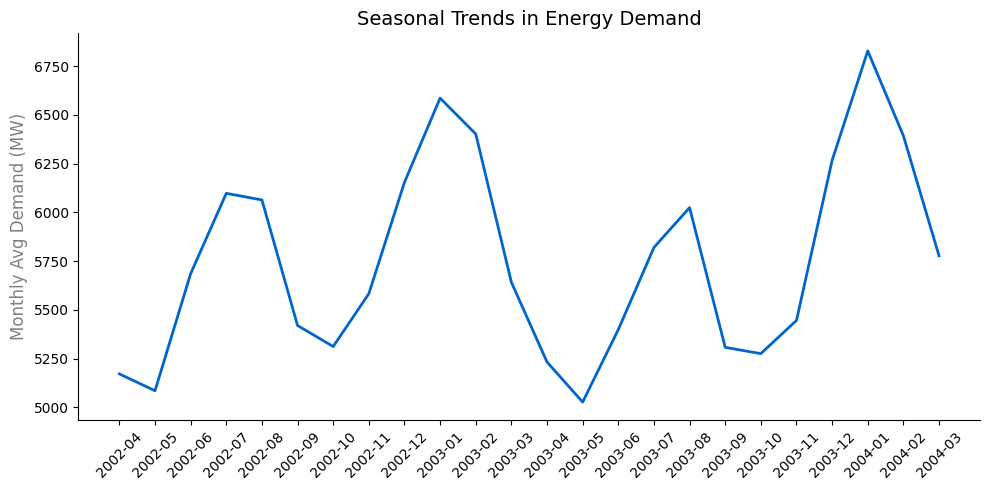

In [16]:
# Seasonal Trends Chart
data['Month_Year'] = data.index.to_period('M')
monthly_avg = data.groupby('Month_Year')['PJMW_MW'].mean().reset_index()
monthly_avg['Month_Year'] = monthly_avg['Month_Year'].astype(str)

# Optional: Filter for a clean range
monthly_avg = monthly_avg[(monthly_avg['Month_Year'] >= '2002-04') & (monthly_avg['Month_Year'] <= '2004-03')]

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg['Month_Year'], monthly_avg['PJMW_MW'], color='#0066CC', linewidth=2)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('')
plt.ylabel('Monthly Avg Demand (MW)', fontsize=12, color='gray')
plt.title('Seasonal Trends in Energy Demand', fontsize=14, color='black')
plt.grid(False)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save chart for PPT
plt.savefig('seasonal_trends.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
data.isna().sum() # checks if any column has null value

,0
PJMW_MW,0
Month_Year,0


In [18]:
data.index.isna().sum() # checks if index has null value

np.int64(0)

In [19]:
data1 = data.copy() # create new dataframe with same data

In [20]:
data1

,PJMW_MW,Month_Year
Datetime,,
2002-04-01 01:00:00,4374,2002-04
2002-04-01 02:00:00,4306,2002-04
2002-04-01 03:00:00,4322,2002-04
2002-04-01 04:00:00,4359,2002-04
2002-04-01 05:00:00,4436,2002-04
...,...,...
2018-08-02 20:00:00,6545,2018-08
2018-08-02 21:00:00,6496,2018-08
2018-08-02 22:00:00,6325,2018-08


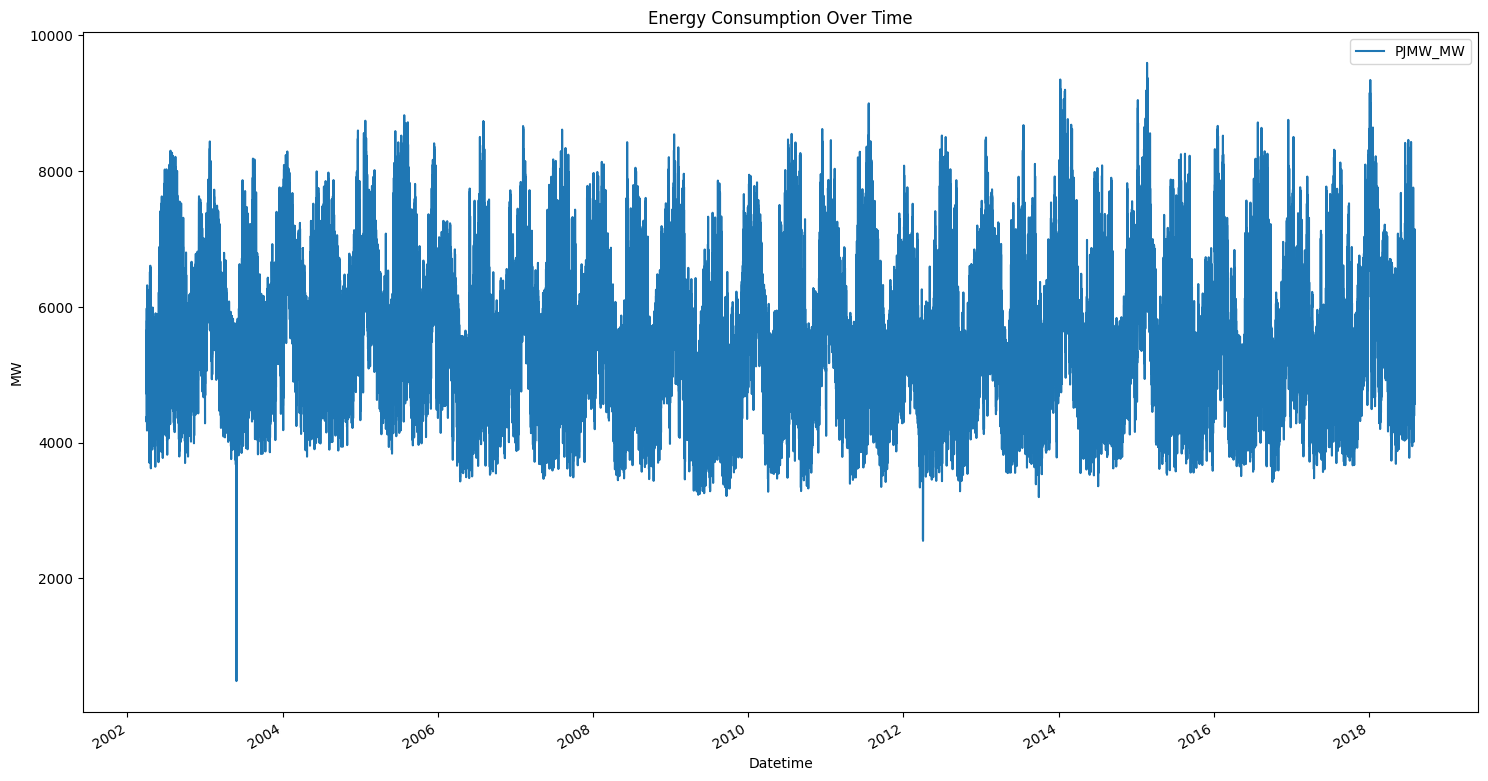

In [21]:
# plots the data
data1.plot(figsize=(18, 10), title='Energy Consumption Over Time', ylabel='MW');

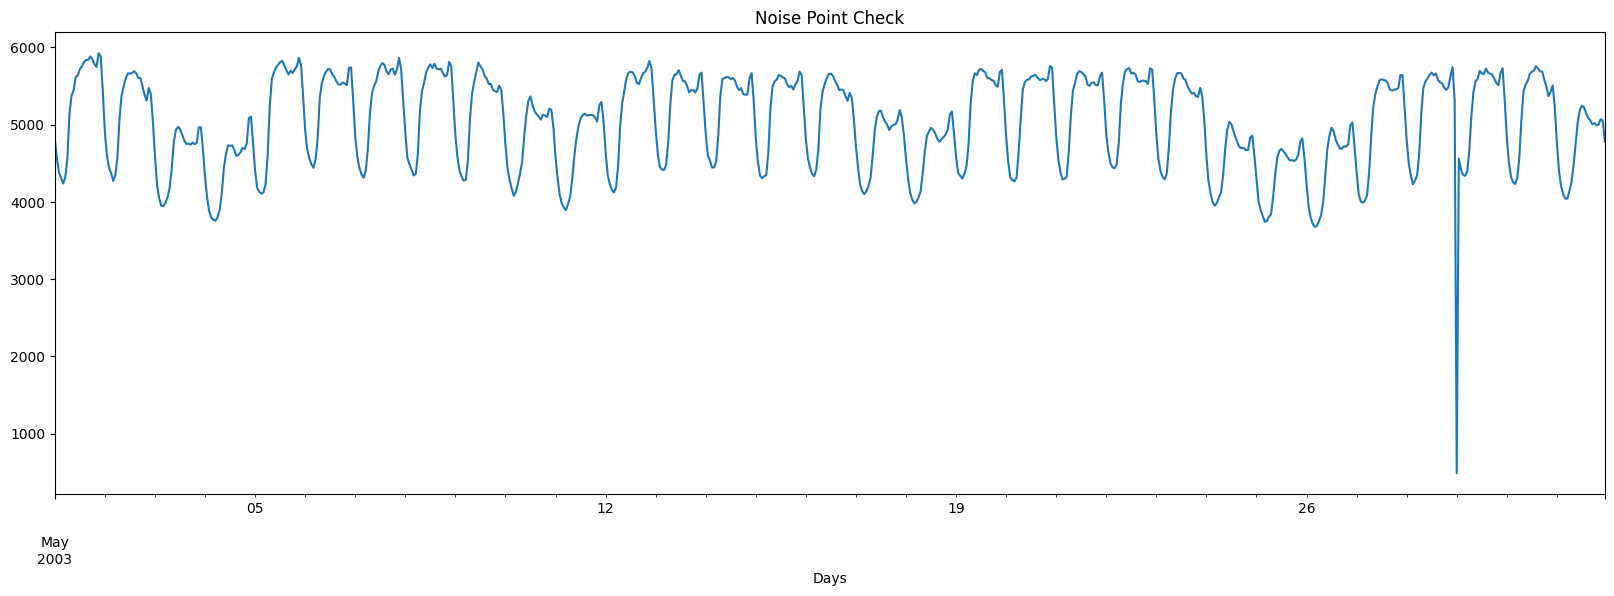

In [22]:
data1.loc['2003-05', 'PJMW_MW'].plot(figsize=(20, 6), xlabel='Days', title='Noise Point Check')
plt.show()

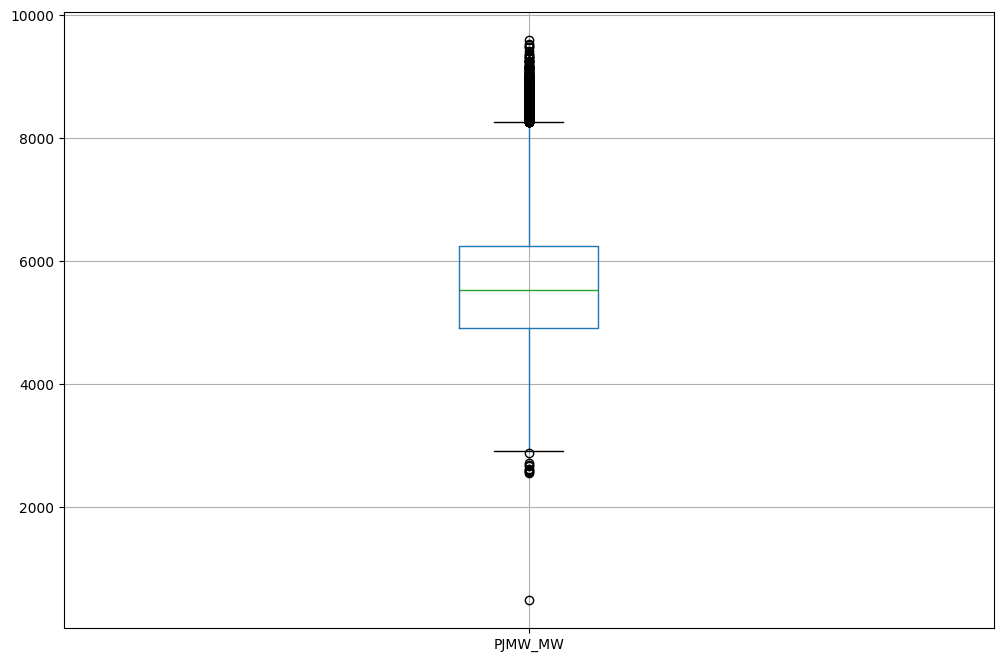

In [23]:
data1.boxplot(figsize = (12,8));

In [24]:
data1 = data1.asfreq('H') # It generates missing houly timestamp

In [25]:
data1

,PJMW_MW,Month_Year
Datetime,,
2002-04-01 01:00:00,4374.0,2002-04
2002-04-01 02:00:00,4306.0,2002-04
2002-04-01 03:00:00,4322.0,2002-04
2002-04-01 04:00:00,4359.0,2002-04
2002-04-01 05:00:00,4436.0,2002-04
...,...,...
2018-08-02 20:00:00,6545.0,2018-08
2018-08-02 21:00:00,6496.0,2018-08
2018-08-02 22:00:00,6325.0,2018-08


In [26]:
data1['PJMW_MW'] = data1['PJMW_MW'].interpolate() # Fills the Nan values based on nearby values

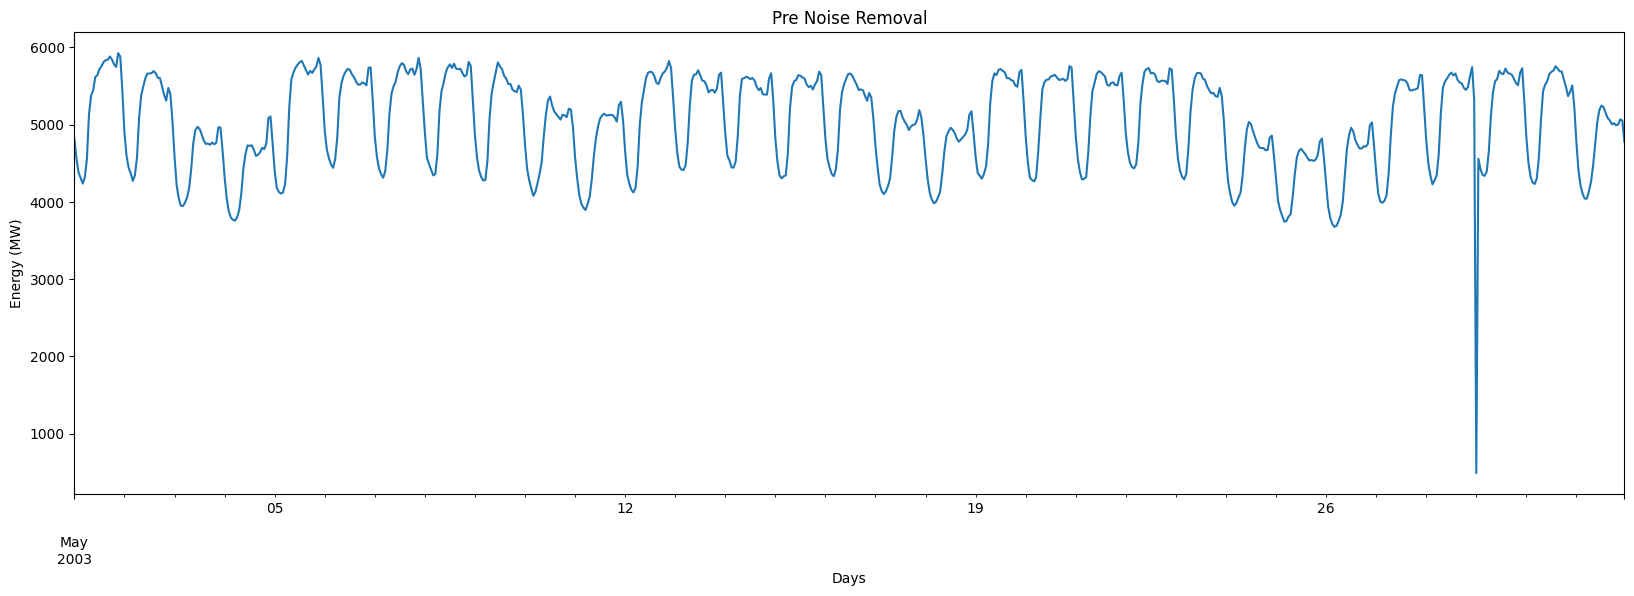

In [27]:
data1.loc['2003-05', 'PJMW_MW'].plot(figsize=(20, 6), title='Pre Noise Removal')
plt.xlabel('Days')
plt.ylabel('Energy (MW)')
plt.show()

In [28]:
# Consdering noise value below 1000 because all other values are close to 4000
threshold = 1000
# Calculates the moving average by taking 12 value before center and 11 value after center
# and 1 center value to calculate mean
# we take window = 24 because data is of hourly basis
rolling_avg = data1['PJMW_MW'].rolling(window = 24, center=True).mean()
# It replaces any abnormal low values (like outliers or noise below threshold)
# with the rolling average at that point
data1['PJMW_MW'] = data1['PJMW_MW'].mask(data1['PJMW_MW'] < threshold, rolling_avg)

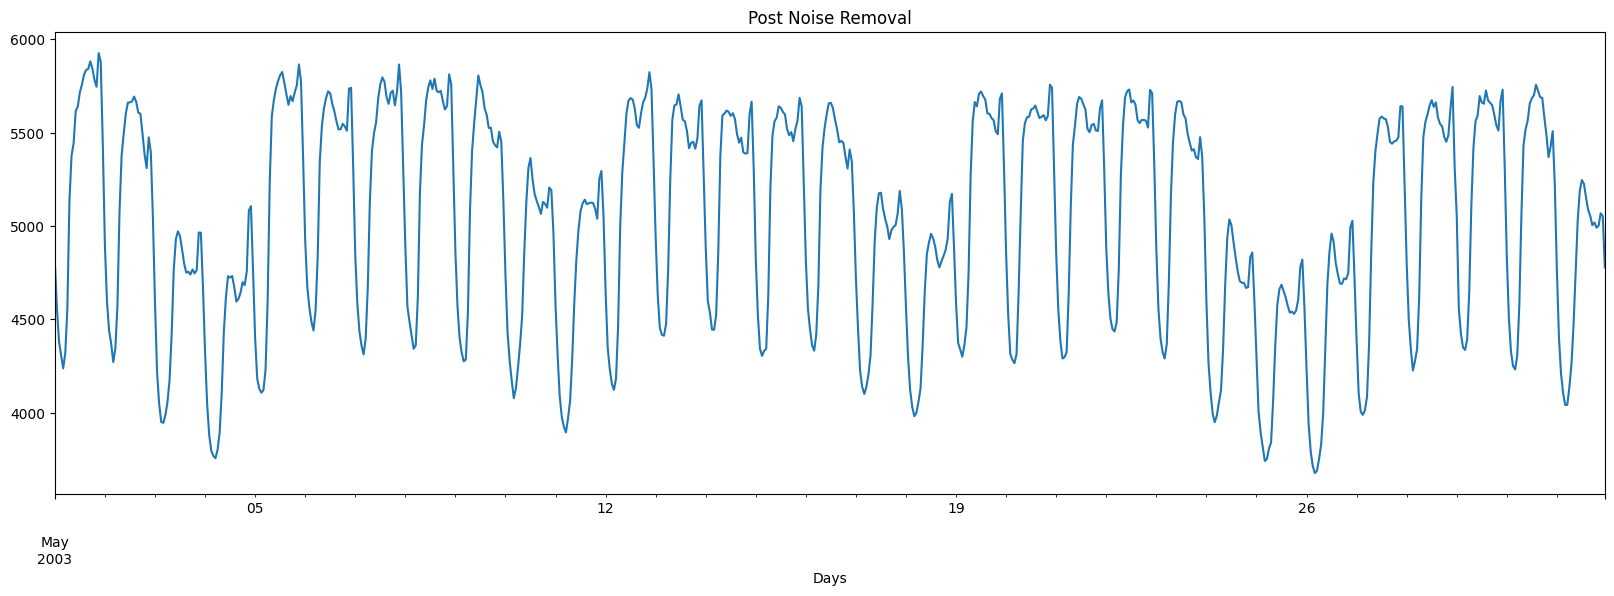

In [29]:
data1.loc['2003-05', 'PJMW_MW'].plot(figsize=(20, 6), title='Post Noise Removal', xlabel='Days')
plt.show()

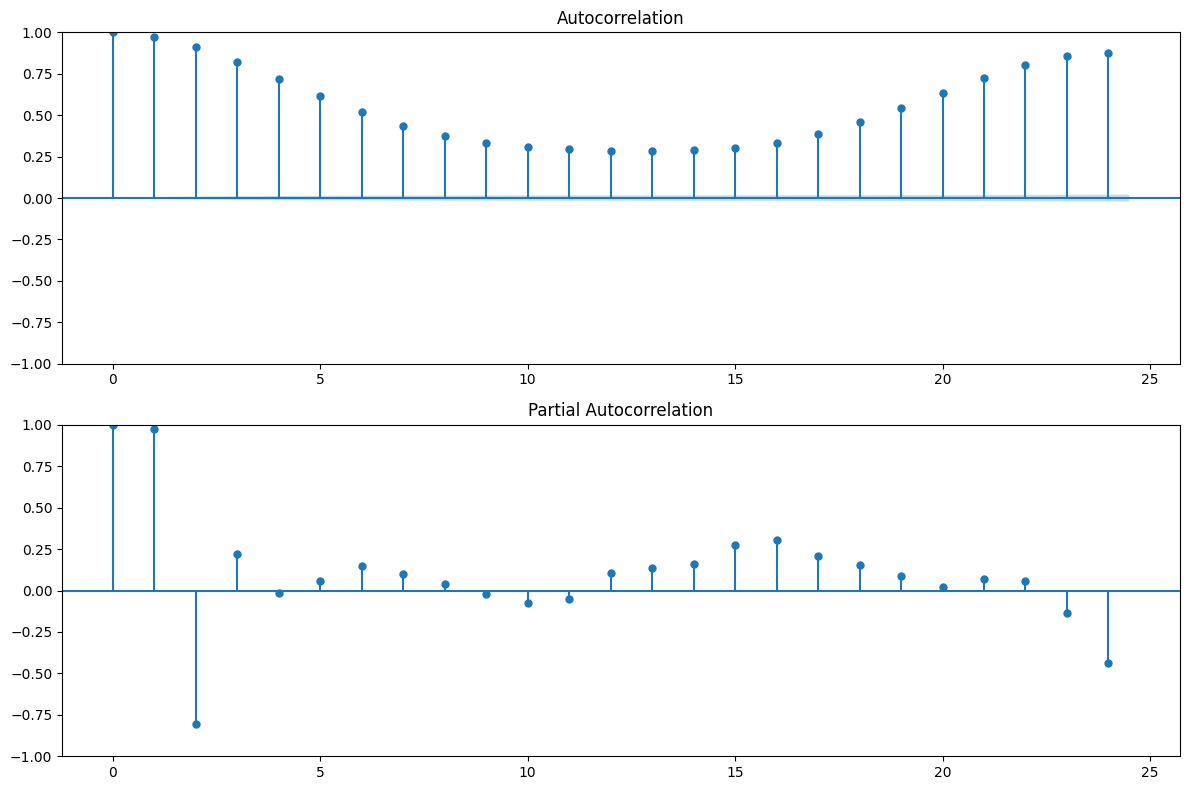

In [30]:
series = data1.iloc[:, 0] # Get column
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, lags = 24, ax = ax[0]) # Shows correlation with past 24 lags
plot_pacf(series, lags = 24, ax = ax[1]) # Shows direct correlation with past lags

plt.tight_layout()
plt.show()

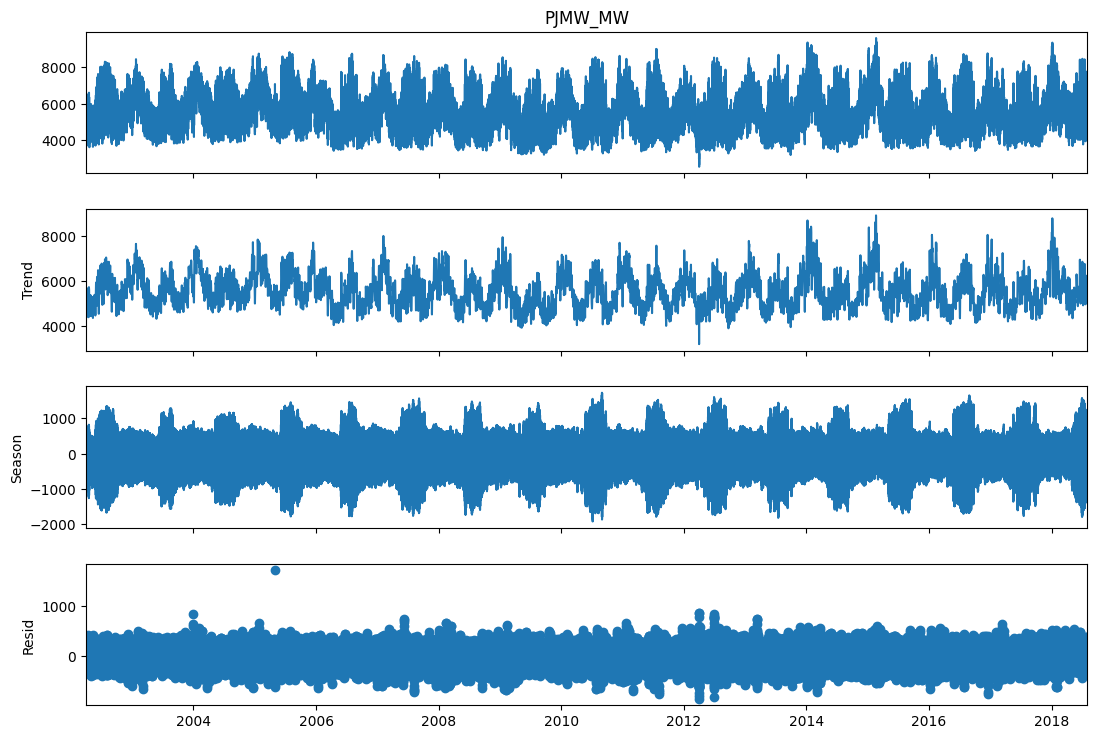

In [31]:
# Apply STL
stl = STL(series, period = 24) # Calculates Daily Seasonality
result = stl.fit()
result.plot()
plt.gcf().set_size_inches(12, 8)
plt.show()

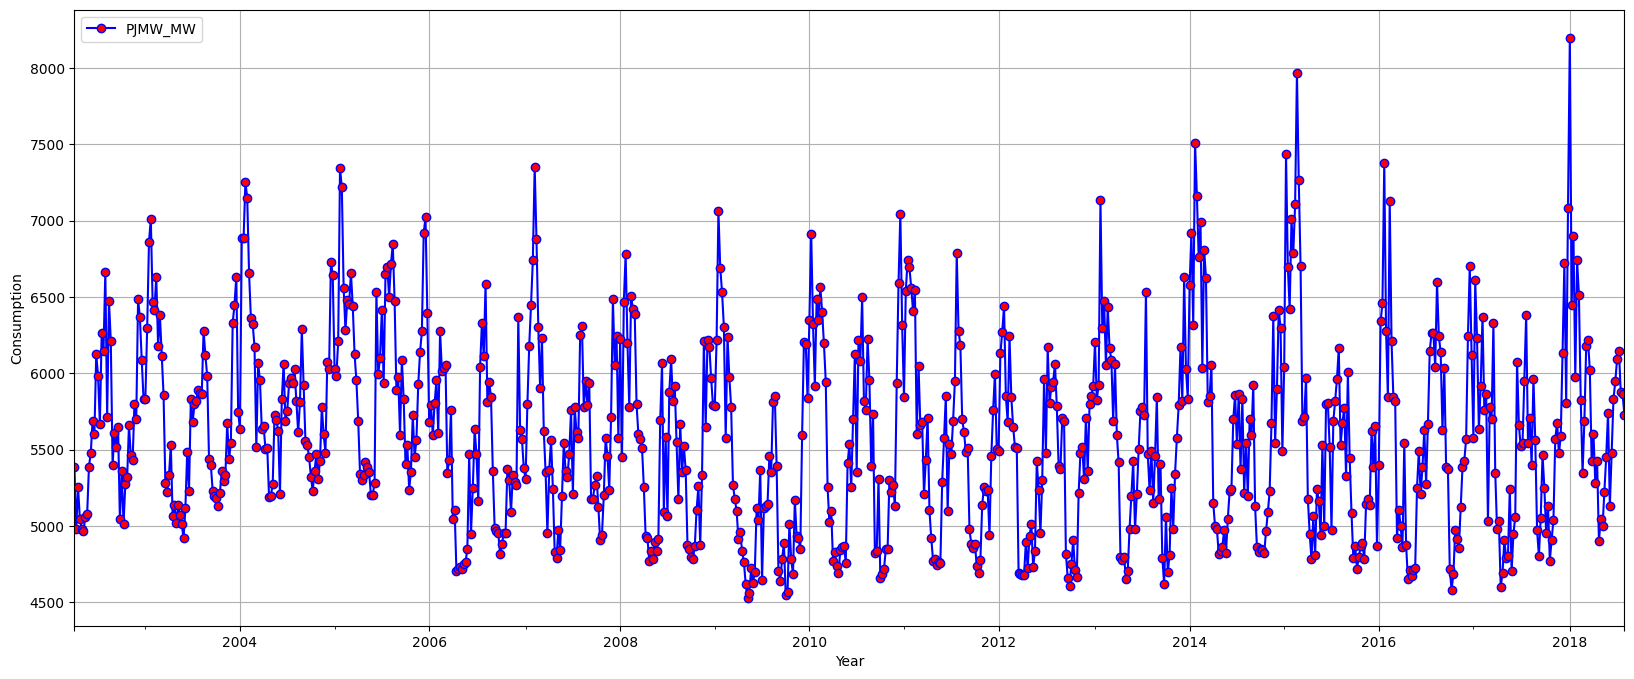

In [32]:
# Plot weekly average power consumption
data1.resample('W').mean().plot(marker='o', figsize = (20,8), color='blue', markerfacecolor='red');
plt.ylabel('Consumption')
plt.xlabel('Year')
plt.grid(True)

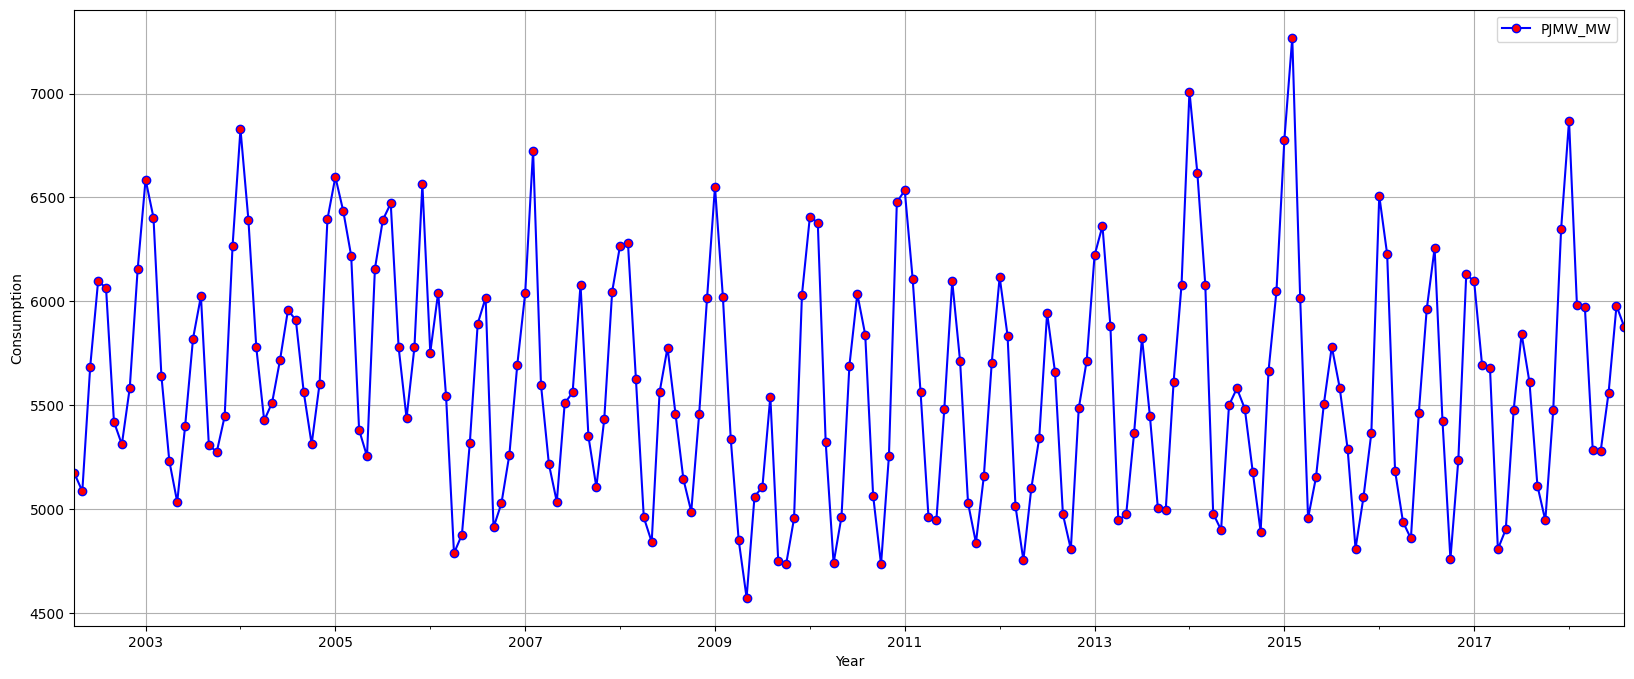

In [33]:
# Plot montly average power consumption
data1.resample('M').mean().plot(marker='o', figsize = (20,8), color='blue', markerfacecolor='red');
plt.ylabel('Consumption')
plt.xlabel('Year')
plt.grid(True)

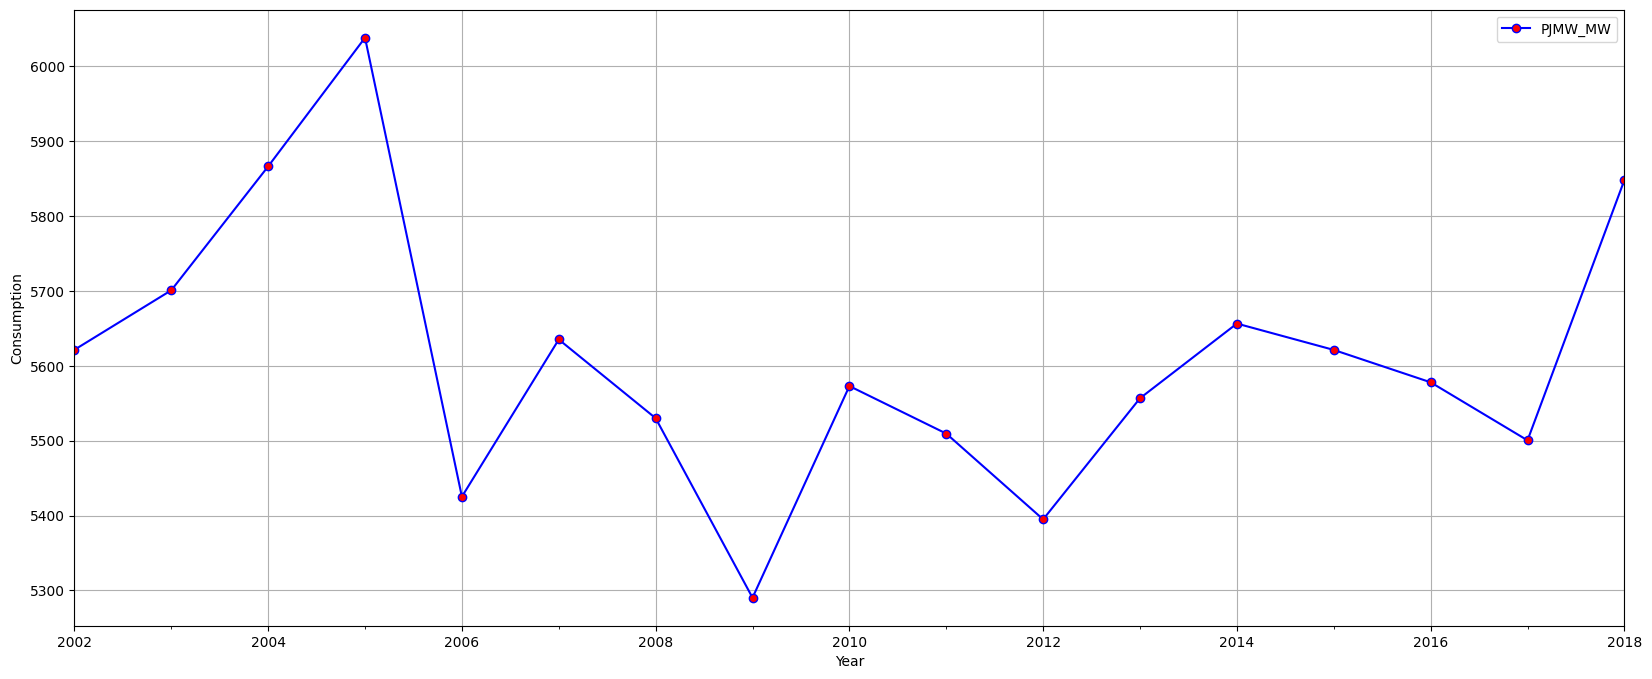

In [34]:
# Plot year average power consumption
data1.resample('Y').mean().plot(marker='o', figsize = (20,8), color='blue', markerfacecolor='red');
plt.ylabel('Consumption')
plt.xlabel('Year')
plt.grid(True)

In [35]:
# Adfuller test to determine whether the data is stationary or not
# Defining Hypothesis
# Null Hypothesis (H0) = Data is not stationary
# Alternate Hypothesis (H1) = Data is stationary

result1 = adfuller(data1.iloc[:, 0]) # Get Column
if result1[1] < 0.05: # Gets the p-value
    print('Reject Null Hypothesis (Data is Stationary)')
else:
    print('Failed to reject null hypothesis (Data is not Stationary)')

Reject Null Hypothesis (Data is Stationary)


In [36]:
mean_value = data1['PJMW_MW'].mean()
std_dev = data1['PJMW_MW'].std()

print(f"Mean of the data: {mean_value}")
print(f"Standard deviation of the data: {std_dev}")

if abs(mean_value) < 1e-9 and abs(std_dev - 1) < 1e-9: # Check if mean is close to 0 and std dev is close to 1
    print("The data is likely standardized.")
else:
    print("The data is not standardized.")

Mean of the data: 5602.246359053843
Standard deviation of the data: 979.0853340221549
The data is not standardized.


###**Train-Test Split**

In [37]:
train = data.iloc[:-24*30]['PJMW_MW'].astype(float)
test = data.iloc[-24*30:]['PJMW_MW'].astype(float)
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (142482,)
Test shape: (720,)


# **Model Building**

#**ARIMA Model**

In [38]:
from statsmodels.tsa.arima.model import ARIMA

# defining the ARIMA model with order (2,1,2)
# (p,d,q) = (2,1,2) are the parameters for ARIMA, we can tune them later
arima_model = ARIMA(train, order=(2,1,2))

# Fiting the ARIMA model using the training data
arima_fit = arima_model.fit()

# Making forecast for the same number of steps as the test data
forecast = arima_fit.forecast(steps=len(test))


In [39]:
models_dict = {}  # create this only once if not already
models_dict['ARIMA'] = arima_fit

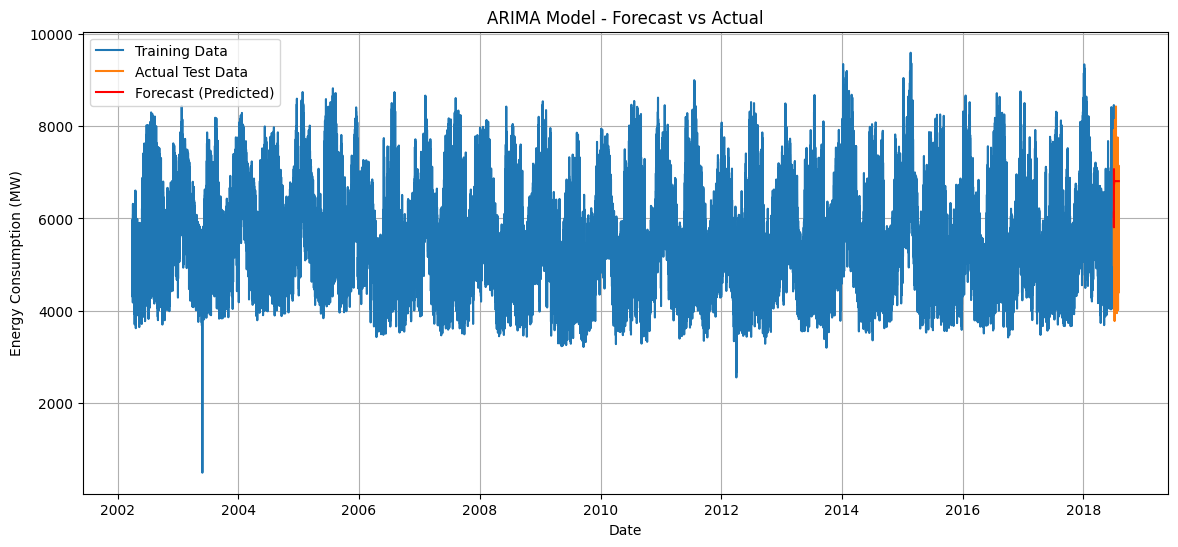

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='Forecast (Predicted)', color='red')
plt.xlabel("Date")
plt.ylabel("Energy Consumption (MW)")
plt.title("ARIMA Model - Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



Mean Absolute Error (MAE): 1132.17
Root Mean Squared Error (RMSE): 1376.04


In [42]:
# Evaluation
arima_mae = mean_absolute_error(test, forecast)
arima_rmse = np.sqrt(mean_squared_error(test, forecast))

In [43]:
models_dict['ARIMA'] = {
    'model': arima_fit,
    'forecast': forecast,
    'mae': arima_mae,
    'rmse': arima_rmse
}

print(f"ARIMA MAE: {arima_mae:.2f}")
print(f"ARIMA RMSE: {arima_rmse:.2f}")

ARIMA MAE: 1132.17
ARIMA RMSE: 1376.04


#**Holt-Winter Mode**l

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Reduced combinations for speed
trend_options = ['add', None]
seasonal_options = ['add']
seasonal_periods_options = [24]  # assuming hourly data with daily seasonality

best_rmse = float('inf')
best_config = None
best_model = None
best_forecast = None

for trend in trend_options:
    for seasonal in seasonal_options:
        for sp in seasonal_periods_options:
            try:
                model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=sp)
                fit = model.fit(optimized=True, use_brute=True)  #  Faster convergence
                forecast = fit.forecast(len(test))
                rmse = np.sqrt(mean_squared_error(test, forecast))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_config = (trend, seasonal, sp)
                    best_model = fit
                    best_forecast = forecast
            except:
                continue

# Evaluate best model
best_mae = mean_absolute_error(test, best_forecast)

# Save to dictionary
models_dict['HoltWinters_Tuned'] = {
    'model': best_model,
    'forecast': best_forecast,
    'mae': best_mae,
    'rmse': best_rmse,
    'params': {
        'trend': best_config[0],
        'seasonal': best_config[1],
        'seasonal_periods': best_config[2]
    }
}

print(" Best Holt-Winters Parameters:")
print(f"Trend: {best_config[0]}, Seasonal: {best_config[1]}, Seasonal Periods: {best_config[2]}")
print(f"MAE: {best_mae:.2f}")
print(f"RMSE: {best_rmse:.2f}")

 Best Holt-Winters Parameters:
Trend: None, Seasonal: add, Seasonal Periods: 24
MAE: 909.35
RMSE: 1029.90


#**Prophet Model**

In [45]:
!pip install prophet --quiet

In [47]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train & Test DataFrame in Prophet format
train_df = pd.DataFrame({'ds': train.index, 'y': train.values.squeeze()})
test_df = pd.DataFrame({'ds': test.index, 'y': test.values.squeeze()})

#  Tuned Prophet model
prophet_model = Prophet(
    seasonality_mode='additive',              # or 'multiplicative'
    changepoint_prior_scale=0.1,              # default: 0.05
    seasonality_prior_scale=10.0,             # default: 10.0
    daily_seasonality=True,                   # enable daily patterns
    weekly_seasonality=True,                  # enable weekly patterns
    yearly_seasonality=False                  # skip yearly if hourly data
)

# Fit model
prophet_model.fit(train_df)

# Create future dataframe (test period length)
future = prophet_model.make_future_dataframe(periods=len(test), freq='H')

# Forecast
forecast = prophet_model.predict(future)

# Extract forecasted values for test period
prophet_forecast = forecast.iloc[-len(test):]['yhat'].values

# Evaluation
prophet_mae = mean_absolute_error(test.values, prophet_forecast)
prophet_rmse = np.sqrt(mean_squared_error(test.values, prophet_forecast))

# Save to model dictionary
models_dict['Prophet'] = {
    'model': prophet_model,
    'forecast': prophet_forecast,
    'mae': prophet_mae,
    'rmse': prophet_rmse
}

# Print results
print(f" Prophet MAE: {prophet_mae:.2f}")
print(f" Prophet RMSE: {prophet_rmse:.2f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbrj0j3qx/bfgz7ed3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbrj0j3qx/1vuf5_62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79781', 'data', 'file=/tmp/tmpbrj0j3qx/bfgz7ed3.json', 'init=/tmp/tmpbrj0j3qx/1vuf5_62.json', 'output', 'file=/tmp/tmpbrj0j3qx/prophet_model0nhc93qe/prophet_model-20250814112607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet MAE: 515.17
 Prophet RMSE: 692.78


#**XGBoost Regressor Model**

In [48]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [49]:
def create_supervised(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i - n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Set number of lag features
n_lags = 24  # last 24 hours

# Prepare training data
X_train, y_train = create_supervised(train.values.squeeze(), n_lags)

# Prepare testing data
full_series = np.concatenate([train.values.squeeze(), test.values.squeeze()])
X_test, y_test = create_supervised(full_series, n_lags)
X_test = X_test[-len(test):]  # Only take test part
y_test = y_test[-len(test):]

In [50]:
#Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)

#Predict
xgb_forecast = xgb_model.predict(X_test)

#Evaluate
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))


In [51]:
models_dict['XGBoost'] = {
    'model': xgb_model,
    'forecast': xgb_forecast,
    'mae': xgb_mae,
    'rmse': xgb_rmse
}


print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

XGBoost MAE: 66.04
XGBoost RMSE: 83.90


#**LSTM (Long Short-Term Memory) Model**

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Lag-based supervised data
def create_supervised(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i - n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Set number of lags
n_lags = 24

# Reshape train & test to 2D before scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Prepare training data
X_train, y_train = create_supervised(train_scaled.squeeze(), n_lags)

# Prepare testing data
full_series = np.concatenate([train_scaled.squeeze(), test_scaled.squeeze()])
X_test, y_test = create_supervised(full_series, n_lags)
X_test = X_test[-len(test):]
y_test = y_test[-len(test):]

# Reshape input to [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_lags, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
lstm_pred_scaled = model.predict(X_test, verbose=0)

# Inverse transform predictions
lstm_forecast = scaler.inverse_transform(lstm_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
lstm_mae = mean_absolute_error(y_actual, lstm_forecast)
lstm_rmse = np.sqrt(mean_squared_error(y_actual, lstm_forecast))

# Save in models_dict
models_dict['LSTM'] = {
    'model': model,
    'forecast': lstm_forecast.flatten(),
    'mae': lstm_mae,
    'rmse': lstm_rmse
}

# Print results
print(f"LSTM MAE: {lstm_mae:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")


LSTM MAE: 70.76
LSTM RMSE: 89.62


In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1:  Model Performance Table
comparison_results = []

for model_name, model_data in models_dict.items():
    comparison_results.append({
        'Model': model_name,
        'MAE': round(model_data['mae'], 2),
        'RMSE': round(model_data['rmse'], 2)
    })

# Create DataFrame and sort
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values(by='RMSE')

print(" Model Comparison :")
print(comparison_df)


 Model Comparison :
               Model      MAE     RMSE
3            XGBoost    66.04    83.90
4               LSTM    70.76    89.62
2            Prophet   515.17   692.78
1  HoltWinters_Tuned   909.35  1029.90
0              ARIMA  1132.17  1376.04


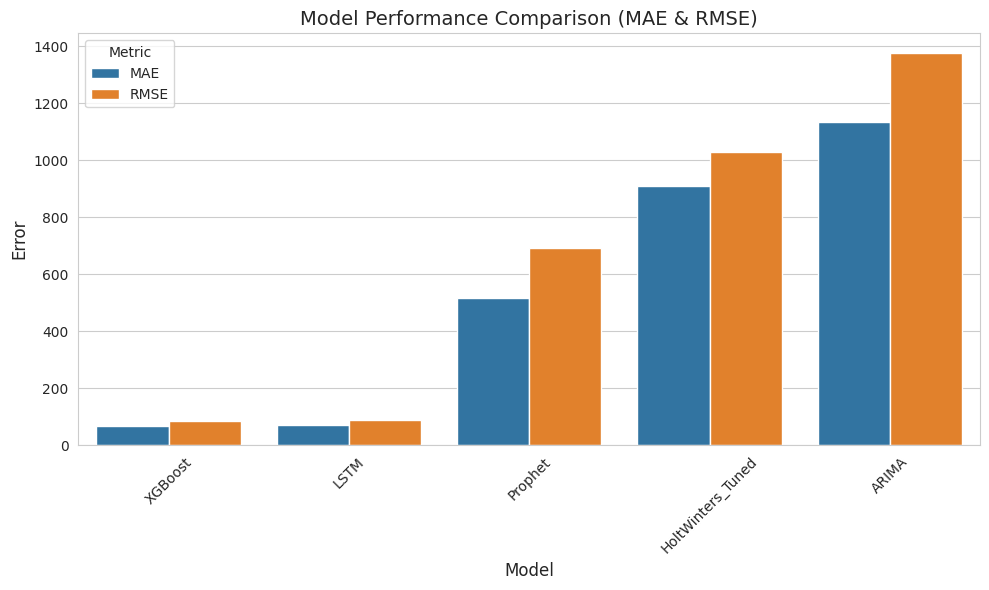

In [54]:
import seaborn as sns

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Melt the DataFrame for side-by-side bars
melted_df = comparison_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE'],
                               var_name='Metric', value_name='Value')

# Create barplot
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_df)

# Add labels and title
plt.title("Model Performance Comparison (MAE & RMSE)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Show the plot
plt.tight_layout()
plt.show()


In [55]:
import xgboost as xgb
import pandas as pd

# Copy data
df = data.copy()

# 1. Convert Month_Year (Period) to timestamp, then to ordinal number
df['Month_Year'] = df['Month_Year'].dt.to_timestamp()
df['Month_Year'] = df['Month_Year'].apply(lambda x: x.toordinal())

# 2. Create lag features
df['lag_1'] = df['PJMW_MW'].shift(1)
df['lag_2'] = df['PJMW_MW'].shift(2)

# 3. Rolling average feature
df['rolling_mean_3'] = df['PJMW_MW'].shift(1).rolling(window=3).mean()

# 4. Date-based features from index
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# 5. Drop rows with NaN values due to shift/rolling
final_df = df.dropna()

# 6. Features & target
X = final_df.drop(columns='PJMW_MW')
y = final_df['PJMW_MW']

# 7. Train final model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Generate future dates
last_date = final_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# 2. Start with latest known values
history = final_df['PJMW_MW'].copy()
future_preds = []

for date in future_dates:
    # Prepare lag features from latest history
    lag_1 = history[-1]
    lag_2 = history[-2]
    rolling_mean_3 = history[-3:].mean()
    dayofweek = date.dayofweek
    month = date.month

    # Create input DataFrame for prediction
    month_year = int(f"{date.year}{date.month:02d}")
    input_data = pd.DataFrame([[month_year, lag_1, lag_2, rolling_mean_3, dayofweek, month]],
                              columns=['Month_Year', 'lag_1', 'lag_2', 'rolling_mean_3', 'dayofweek', 'month'])


    # Predict using the trained model
    y_pred = xgb_model.predict(input_data)[0]
    future_preds.append(y_pred)

    # Add prediction back to history for next loop
    history.loc[date] = y_pred


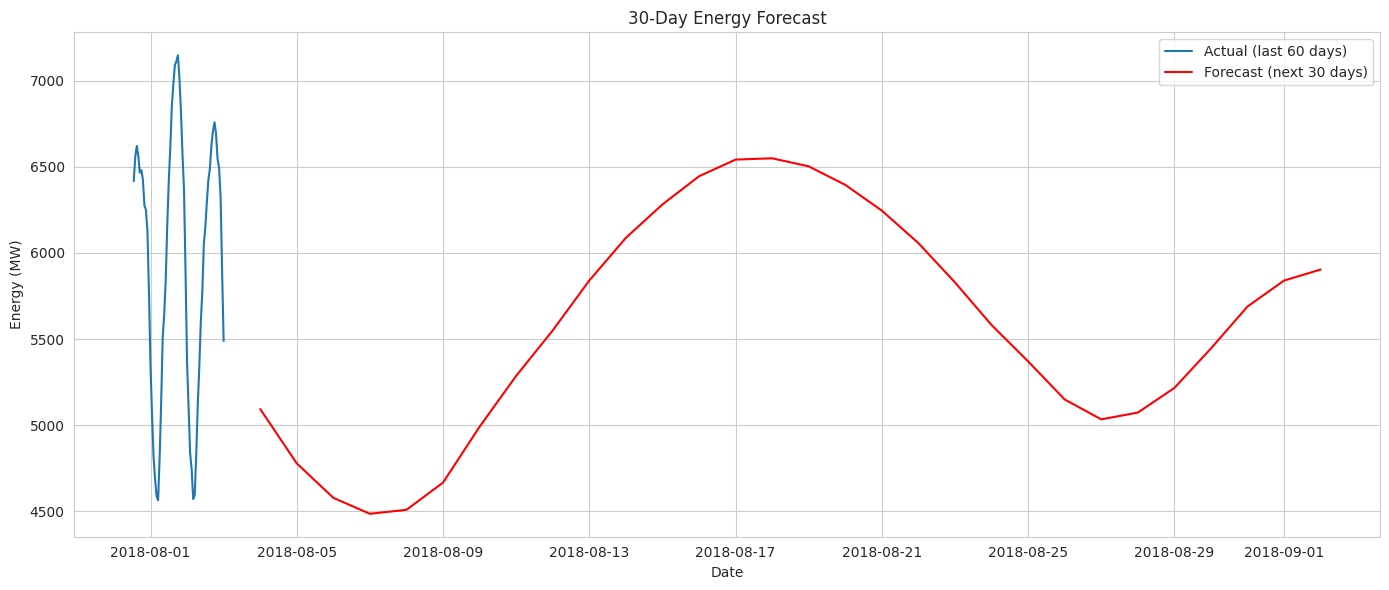

In [57]:
plt.figure(figsize=(14,6))
plt.plot(final_df.index[-60:], final_df['PJMW_MW'][-60:], label="Actual (last 60 days)")
plt.plot(future_dates, future_preds, color='red', label="Forecast (next 30 days)")
plt.title("30-Day Energy Forecast")
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


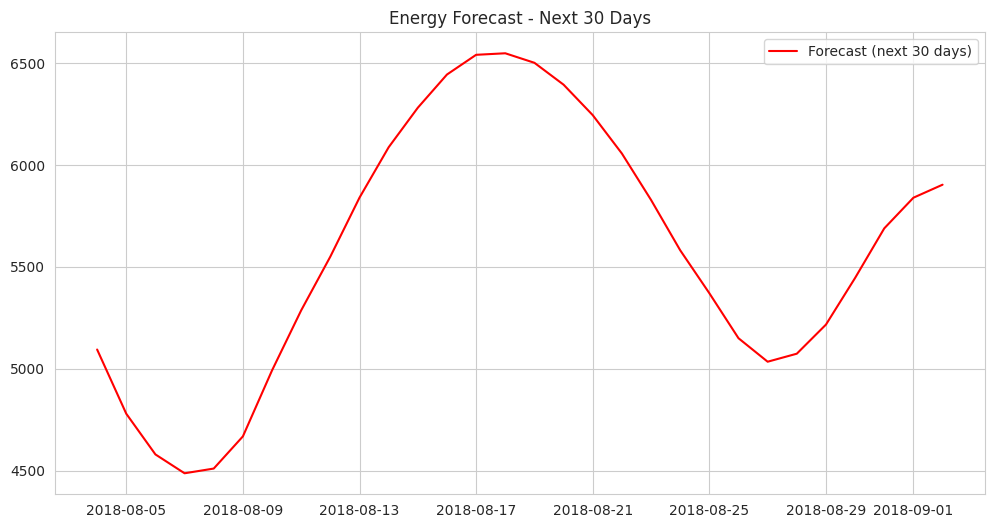

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_preds, label='Forecast (next 30 days)', color='red')
plt.legend()
plt.title("Energy Forecast - Next 30 Days")
plt.show()


In [59]:
import joblib
joblib.dump(xgb_model, 'xgb_energy_forecast_model.joblib')
from google.colab import files
files.download('xgb_energy_forecast_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
import xgboost as xgb
import joblib
joblib.dump(xgb_model, 'daily_energy_forecast_model.joblib')
from google.colab import files
files.download('daily_energy_forecast_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deploment Link**

https://energy-consumption-forecast-app.streamlit.app/